# Simple Tensorflow Models

In this Notebook we will be working on some simple tensorflow models for the classification. We will try out:
- Baseline (a threshhold model to compare against)
- Feed-forward network
- LSTM network
- Auto-encoder for anomaly detection

## Setup of Data 

In [2]:
import os

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt


import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Colors using scheme
c = ["#" + i for i  in "264653-2a9d8f-e9c46a-f4a261-e76f51".split("-")]

2022-01-26 14:28:02.286838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 14:28:02.286888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data_trace_high = pd.read_csv("/mnt/c/Users/johan/Desktop/CMT_project/data/traces_high.txt", sep = " ", header = None)
data_trace_low  = pd.read_csv("/mnt/c/Users/johan/Desktop/CMT_project/data/traces_low.txt",  sep = " ", header = None)

In [4]:
rand_seed  = 1969
test_split = 0.2


high_labels = np.ones(data_trace_high.shape[0])
low_labels  = np.zeros(data_trace_low.shape[0])

data        = pd.concat([data_trace_high, data_trace_low])
labels      = np.concatenate([high_labels,     low_labels])


X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = test_split)

## Baseline Models
We will try to make some simple models, which we can use as a baseline which our Neural Networks have to compete with.

### Threshhold

Simple models reading out simple characteristics

In this model we simply look at timesteps between 50 and 100 and take the highest values. We will use that value as threshhold value in a ROC-curve

AUC score: 0.876


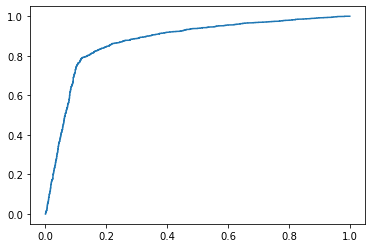

In [5]:
peak_height = X_test.iloc[:, 50:150].max(1)

roc         = roc_curve(Y_test, peak_height)
auc         = roc_auc_score(Y_test, peak_height)

plt.plot(roc[0], roc[1])

print(f"AUC score: {auc:.3f}")


### XGBoost
Pretty much a boosted decision tree from the box. 

In [6]:
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler

def preprocess_xgboost(df):
    data_fft = np.fft.rfft(df)

    fft_abs   = np.abs(data_fft)
    phase     = np.angle(data_fft)
    phase_cos = np.cos(phase)
    phase_sin = np.sin(phase) 

    data      = np.concatenate([df.to_numpy(), fft_abs, phase_cos, phase_sin], axis = 1)

    return data

xgboost_X_train = preprocess_xgboost(X_train)
xgboost_X_test  = preprocess_xgboost(X_test)


classifier      = XGBClassifier()


classifier.fit(xgboost_X_train, Y_train)


/home/johannbs/anaconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

0.8782646383836141


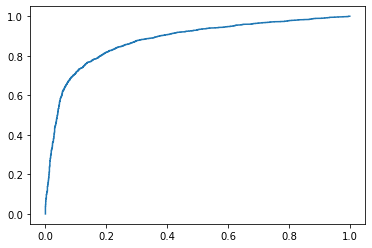

In [35]:
xgboost_scores = classifier.predict_proba(xgboost_X_test)

print(roc_auc_score(Y_test, xgboost_scores[:, 1]))


xgboost_roc = roc_curve(Y_test, xgboost_scores[:, 1])

plt.plot(xgboost_roc[0], xgboost_roc[1])

## Neural Network Models


### Simple Feed Forward

In [54]:
# Scale data
scaler = RobustScaler()

X_train_scaled = np.expand_dims(scaler.fit_transform(X_train), -1)
X_test_scaled  = np.expand_dims(scaler.transform(X_test), -1)

In [55]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LSTM, Embedding, SimpleRNN
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [63]:
hidden_states = 32
rnn_states    = 16
layers        = 3
activation    = "relu"
epochs        = 3
learning_rate = 0.1
dropout       = 0.1
batch_size    = 64


input = Input((220, 1))

# x     = Dense(hidden_states)(input)

x     = SimpleRNN(rnn_states,  return_sequences = True, activation = "tanh")(input)
x     = SimpleRNN(rnn_states, activation = "tanh")(x)

x     = Dense(hidden_states // 2, activation = "relu")(x)

out = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = input, outputs = out, name = "LSTM")



model.compile(  loss      = BinaryCrossentropy(from_logits = False),
                metrics   = [BinaryAccuracy(name = "Acc"), AUC(name = "AUC")],
                optimizer = Adam(learning_rate = learning_rate))

model.summary()

model.fit(X_train_scaled, Y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1)


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 220, 1)]          0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 220, 16)           288       
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 16)                528       
                                                                 
 dense_67 (Dense)            (None, 16)                272       
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
225/225 [==============================] - 27s 115

In [30]:
model.evaluate(X_train)

500/500 [==============================] - 0s 916us/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00


[0.0, 0.0]